In [ ]:
!pip3 install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 KB 3.6 MB/s eta 0:00:00


In [ ]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 20.3 MB/s eta 0:00:00


In [ ]:
import snscrape.modules.twitter as sntwitter

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer

ModuleNotFoundError: ignored

In [ ]:
import pandas as pd
import itertools
import numpy as np
from scipy.special import softmax
from pathlib import Path
import re
from openpyxl import load_workbook,Workbook
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
from scipy.stats import spearmanr
import networkx as nx
import seaborn as sns

In [ ]:
# mounting google cloud

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = Path.cwd()
path = '/content/drive/MyDrive/MyColab/ethics'
excel_path = f'{path}/tsa8new.xlsx'
number_of_tweets = 8000
labels = ['negative','nuetral','positive']

In [ ]:
query = '(to:realDonaldTrump) until:2021-02-01 since:2020-11-01'
# query = '(to:joeBiden) until:2021-02-01 since:2020-11-01'

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
def getDataset():
  all = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
      query).get_items(), number_of_tweets))
  tot = all.columns.tolist()
  unwanted_num = {'url','rawContent', 'id', 'user'}
  list1 = [ele for ele in tot if ele not in unwanted_num]
  df = all.drop(columns=list1)
  return df


In [ ]:
def data_preprocess(content):
    clean_tweet = re.sub("/n \n @[A-Za-z0-9_]+","", content)
    clean_tweet = re.sub("#[A-Za-z0-9_]+","", clean_tweet)
    clean_tweet = re.sub(r"http\S+", "", clean_tweet)
    return clean_tweet


In [ ]:
def getTweetByUser(username,pres,n_of_t):
  query = f'(from:{username})(to:{pres}) until:2021-05-01 since:2020-11-01'
  # query = f'(from:{username})(to:{pres})'
  # query = f'(from:{username})(to:HouseDemocrats) until:2021-02-01 since:2020-11-01'

  all = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
      query).get_items(), n_of_t))
  tot = all.columns.tolist()
  unwanted_num = {'url','rawContent', 'id', 'user'}
  list1 = [ele for ele in tot if ele not in unwanted_num]
  df = all.drop(columns=list1)
  return df


In [ ]:
def create_excel_for_tsa_report():
  wb = Workbook()
  page = wb.active
  # New data to write:
  new_row = [['Name','UserName','Location','Followers','Content','Tweet_url','Negative','Neutral','Positive','Highest']]

  for info in new_row:
      page.append(info)
  wb.save(excel_path)
  wb.close()

In [ ]:
def save_inexcel(Name,UserName,Location,Followers,Content,Tweet_url,Negative,Neutral,Positive,Highest):
    wb = load_workbook(excel_path)
    page = wb.active

    # New data to write:
    new_row = [[Name,UserName,Location,Followers,Content,Tweet_url,Negative,Neutral,Positive,Highest]]

    for info in new_row:
        page.append(info)

    wb.save(filename = excel_path)

In [ ]:
def tsa():
  ds = getDataset()
  for _, row in ds.iterrows():
    s = []
    con = ''
    ds = getTweetByUser(row.user['username'],'realDonaldTrump',2)
    for _, r in ds.iterrows():
      con = f'{con} . {r.rawContent}'
    final_st = data_preprocess(con)
    if str(row.user['displayname']) != '' and str(row.user['location']) != '':
      encoded_input = tokenizer(final_st, return_tensors='pt')
      output = model(**encoded_input)
      scores = output[0][0].detach().numpy()
      scores = softmax(scores)
      for i in range(scores.shape[0]):
          s.append(scores[i])
      highest = labels[s.index(max(s))]
      save_inexcel(str(row.user['displayname']),str(row.user['username']),str(row.user['location']),
                   str(row.user['followersCount']),str(row.rawContent),str(row.url),s[0],s[1],s[2],highest)

In [ ]:
# create new excel file
create_excel_for_tsa_report()

In [ ]:
tsa()

from drive

In [ ]:
# converting excel to dataframe
def excel_to_dataframe(excel_path):
    return pd.read_excel(excel_path)

In [ ]:
final_data = excel_to_dataframe(excel_path)
len(final_data)

2554

In [ ]:
c_df = final_data.loc[final_data['Location'] == 'Alabama, USA']
c_df

,Name,UserName,Location,Followers,Content,Tweet_url,Negative,Neutral,Positive,Highest
888,ericyare,ericyare1,"Alabama, USA",0,@realDonaldTrump fuck you,https://twitter.com/ericyare1/status/135245646...,0.953490,0.039247,0.007263,negative
1369,Ricky Lamont,RickyLamont1970,"Alabama, USA",1317,@realDonaldTrump GOOD RIDDANCE,https://twitter.com/RickyLamont1970/status/135...,0.910443,0.081133,0.008423,negative
2095,SMK Clothing Brand,SmkBrand,"Alabama, USA",7,@realDonaldTrump \n**SMK Clothing Brand**\nhtt...,https://twitter.com/SmkBrand/status/1351371441...,0.133177,0.796913,0.069910,nuetral


<AxesSubplot:title={'center':'Frequency of each Polarity'}, ylabel='freq'>

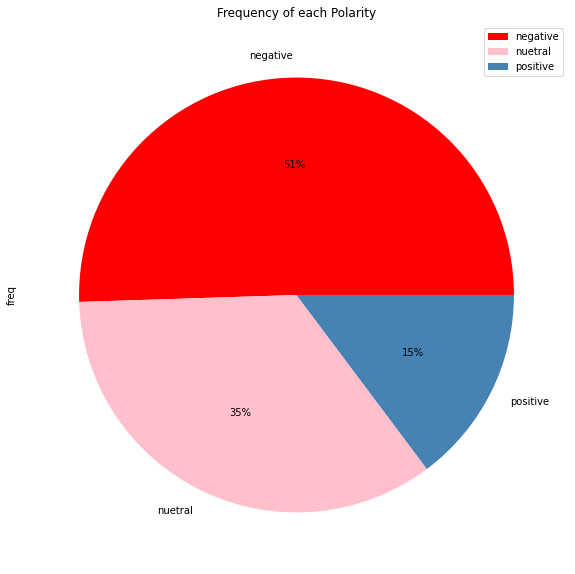

In [ ]:
# how many are negative, positive and nutral
freq = final_data.Highest.value_counts()
freq_pd = pd.DataFrame()
freq_pd['name'] = labels
freq_pd['freq'] = freq.tolist()
freq_pd.groupby(['name']).sum().plot(kind='pie', y='freq', autopct='%1.0f%%',
                                colors = ['red', 'pink', 'steelblue'],
                                title='Frequency of each Polarity',figsize=(15, 10))

In [ ]:
# showing the wordcloud for each polarity
def wordCloud(polarity):
  c_df = final_data.loc[final_data['Highest'] == polarity]
  text = c_df['Content'].values
  wordcloud = WordCloud().generate(str(text))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

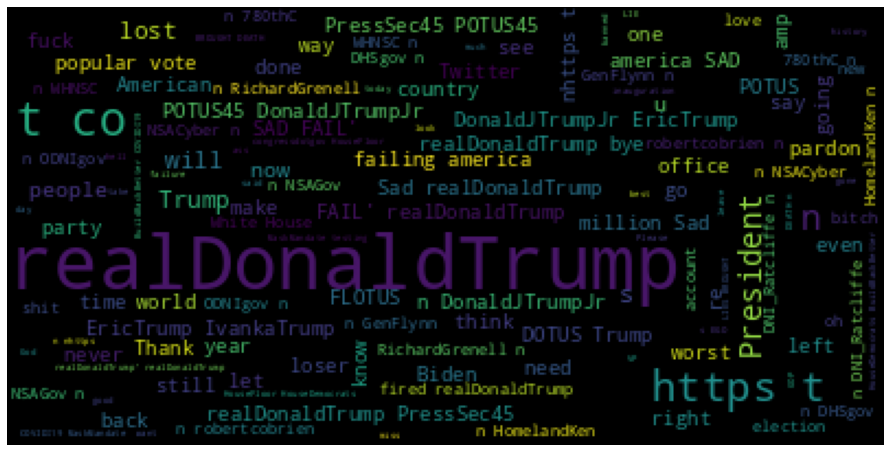

In [ ]:
wordCloud('negative')

In [ ]:
def plot_freq(polarity):
  c_df = final_data.loc[final_data['Highest'] == polarity]
  c_df.drop_duplicates(subset="UserName",
                     keep=False, inplace=True)
  loc_freq = c_df.Location.value_counts()
  freq_loc_pd = pd.DataFrame()
  freq_loc_pd['location'] = loc_freq.index.tolist()
  freq_loc_pd['frequency'] = loc_freq.tolist()
  freq_loc_pd = freq_loc_pd.loc[freq_loc_pd['frequency'] > 2]
  freq_loc_pd.plot(kind='bar',x='location')


In [ ]:
c_df = final_data.loc[final_data['Highest'] == 'negative']
c_df.drop_duplicates(subset="UserName",
                     keep=False, inplace=True)
loc_freq = c_df.Location.value_counts()
freq_loc_pd = pd.DataFrame()
freq_loc_pd['location'] = loc_freq.index.tolist()
freq_loc_pd['frequency'] = loc_freq.tolist()
freq_loc_pd = freq_loc_pd.loc[freq_loc_pd['frequency'] > 4]
freq_loc_pd

<ipython-input-18-a882d8ccc6ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_df.drop_duplicates(subset="UserName",


,location,frequency
0,United States,17
1,USA,8
2,"California, USA",7
3,"England, United Kingdom",7
4,"Texas, USA",5
5,"Washington, DC",5


In [ ]:
fd = final_data.loc[final_data['Positive'] > 0.75]
fd = fd.loc[final_data['Followers'] > 1000]
fd = fd.sort_values(['Followers'], ascending= [False])
fd

,Name,UserName,Location,Followers,Content,Tweet_url,Negative,Neutral,Positive,Highest
1527,Hle Radio,HLERadio,Jennings Louisiana,61628,@realDonaldTrump \n@EricTrump\n@LaraLeaTrump\n...,https://twitter.com/HLERadio/status/1351900321...,0.002159,0.060970,0.936872,positive
1864,Miss Mona,WhalenMona,"Ohio, USA",58943,@realDonaldTrump @POTUS 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸...,https://twitter.com/WhalenMona/status/13516602...,0.002258,0.017106,0.980636,positive
203,Bitcoin Ben,bensemchee,"Wildwood, MO",31743,@realdonaldtrump #bringhimback 😁👍🏻,https://twitter.com/bensemchee/status/13549993...,0.008523,0.198163,0.793314,positive
365,. #ImpeachBiden/Harris #Trump2024,JJDJ1187,"Oak Hill, WV",27753,@realdonaldtrump IS the most popular President...,https://twitter.com/JJDJ1187/status/1354250708...,0.002221,0.018274,0.979505,positive
1161,RedNckDEPLORABLLINDA❌,RoseDru63,"Tuscaloosa,AL",21915,@realDonaldTrump we need a new Trump tracker w...,https://twitter.com/RoseDru63/status/135202322...,0.002485,0.024866,0.972649,positive
...,...,...,...,...,...,...,...,...,...,...
1009,紫苑🍖№24(日中は低浮上💦),sisyokusikou,日本 東京,1337,@realDonaldTrump \n🇯🇵❤️🇺🇸 https://t.co/0BLmOrhuWT,https://twitter.com/sisyokusikou/status/135221...,0.005026,0.182377,0.812597,positive
2409,NIKOZ International,smoothchamp,American Airlines EP.,1251,@realDonaldTrump #PresidentTrump #potustrump\n...,https://twitter.com/smoothchamp/status/1350751...,0.009707,0.200921,0.789372,positive
1341,Jake 🔆 (temp suns fan),_JakesWRLD_,Middle of the pacific ocean,1067,@realDonaldTrump https://t.co/aBwobpzVXW,https://twitter.com/_JakesWRLD_/status/1351945...,0.017119,0.131902,0.850979,positive
1532,🇵🇰Barry Pakistani🇵🇰,Luvpakistani,Planet Earth🌎,1032,@realDonaldTrump Good Luck For Future. I will ...,https://twitter.com/Luvpakistani/status/135189...,0.011486,0.059008,0.929506,positive


<ipython-input-16-81f9fcd7d30d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_df.drop_duplicates(subset="UserName",


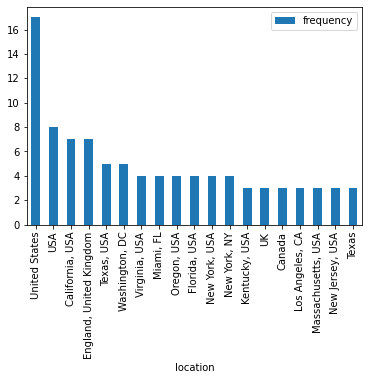

In [ ]:
plot_freq('negative')

In [ ]:
# ploting users with number of follewers and location

In [ ]:
def followers(polarity):
  c_df = final_data.loc[final_data['Highest'] == polarity]
  c_df2 = c_df[["Name", "UserName", "Location", "Followers"]]
  c_df2 = c_df2.sort_values(['Followers'], ascending= [False])
  c_df2 = c_df2.loc[c_df2['Followers'] > 1000]
  freq_loc_pd['location'] = loc_freq.index.tolist()
  freq_loc_pd['frequency'] = loc_freq.tolist()

In [ ]:
def users_with_folowers(polarity):
  c_df = final_data.loc[final_data[polarity] > 0.9]
  c_df2 = c_df[["Name", "UserName", "Content","Location", "Followers"]]
  c_df2 = c_df2.sort_values(['Followers'], ascending= [False])
  c_df2 = c_df2.loc[c_df2['Followers'] > 1000]

  # remove duplicate
  c_df2.drop_duplicates(subset="UserName",
                      keep=False, inplace=True)
  return c_df2

In [ ]:
# message to joe biden
excel_path2 = f'{path}/tsa16i.xlsx'

In [ ]:
def sentiment_with_multiple_data(df):
  for _,r in df.iterrows():
    con = ''
    ds = getTweetByUser(r.UserName,'realDonaldTrump')
    for _, row in ds.iterrows():
      con = f'{con} . {row.rawContent}'
    final_st = data_preprocess(con)
    df.loc['Content'] = final_st
  return ds

In [ ]:
negative_num_folowers = users_with_folowers('Negative')
positive_num_folowers = users_with_folowers('Positive')

In [ ]:
def create_excel_for_tsa_report2(excel_path2,pol):
  wb = Workbook()
  page = wb.active
  # New data to write:
  new_row = [['Name','UserName','Location','Judgement',pol]]

  for info in new_row:
      page.append(info)
  wb.save(excel_path2)
  wb.close()

In [ ]:
def save_inexcel2(Name,UserName,Location,Judgement,Positive,path):
    wb = load_workbook(path)
    page = wb.active

    # New data to write:
    new_row = [[Name,UserName,Location,Judgement,Positive]]

    for info in new_row:
        page.append(info)

    wb.save(filename = path)
    # neg nue posi

In [ ]:
# with respect to donald supporters
# HouseGOP
def tsa2(df,judgement,pol,path):
  for _, r in df.iterrows():
    s = []
    con = ''
    ds = getTweetByUser(r.UserName,'joeBiden',5)
    for _, row in ds.iterrows():
      con = f'{con} . {row.rawContent}'
    final_st = data_preprocess(con)
    if str(r.Location) != '' and final_st != '':
      encoded_input = tokenizer(row.rawContent, return_tensors='pt')
      output = model(**encoded_input)
      scores = output[0][0].detach().numpy()
      scores = softmax(scores)
      for i in range(scores.shape[0]):
          s.append(scores[i])
      save_inexcel2(str(r.Name),str(r.UserName),str(r.Location),judgement,s[pol],path)

In [ ]:
create_excel_for_tsa_report2(excel_path2,'Positive')
# first are trump suporteres, we expect them to write bad things about joe biden
tsa2(positive_num_folowers,0,2,excel_path2)
# second are trump haters, we expect them to write good things about joe biden
tsa2(negative_num_folowers,1,2,excel_path2)

In [ ]:
final_data2 = excel_to_dataframe(excel_path2)

In [ ]:
final_data2

,Name,UserName,Location,Judgement,Positive
0,Miss Mona,WhalenMona,"Ohio, USA",0,0.043330
1,. #ImpeachBiden/Harris #Trump2024,JJDJ1187,"Oak Hill, WV",0,0.010904
2,Jackie @pawpatrol2015,pawpatrol2015,Texas,0,0.025436
3,❌ tonguepiercer ❌ ...👅 tonguepiercer,tonguepiercer,Calif. Some conservatives here,0,0.054311
4,Boudoir Photographer/Entrepreneur,boudoirby,New York-Philadelphia-LA,0,0.013605
5,The Gardener,hmcadena,"Austin, TX",0,0.070923
6,"Kierian, Le Comptable, USA",windsandstrings,United States,0,0.016217
7,Angel...,angel7731,United States,0,0.003459
8,Maggie Shepherd,MaggieS66638762,"Cocoa Beach, FL",0,0.202700
9,wellington miguel🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷,WMiguel_jatai,"Itajaí, Brasil",0,0.062034


In [ ]:
def corr(j,p):
  corr,pvalue = spearmanr(j,p)
  return (corr,pvalue)

In [ ]:
j1 = final_data2.Judgement.tolist()
p1 = final_data2.Positive.tolist()
corr(j1,p1)

0.4829465300469709

In [ ]:
# with respect to negative polarity
create_excel_for_tsa_report2(f'{path}/tsa18i.xlsx','Negative')
# first are trump suporteres, we expect them to write bad things about joe biden
tsa2(positive_num_folowers,1,0,f'{path}/tsa18i.xlsx')
# second are trump haters, we expect them to write good things about joe biden
tsa2(negative_num_folowers,0,0,f'{path}/tsa18i.xlsx')

In [ ]:
final_data3 = excel_to_dataframe(f'{path}/tsa18i.xlsx')

In [ ]:
final_data3

,Name,UserName,Location,Judgement,Negative
0,Miss Mona,WhalenMona,"Ohio, USA",1,0.485879
1,. #ImpeachBiden/Harris #Trump2024,JJDJ1187,"Oak Hill, WV",1,0.871474
2,Jackie @pawpatrol2015,pawpatrol2015,Texas,1,0.650956
3,❌ tonguepiercer ❌ ...👅 tonguepiercer,tonguepiercer,Calif. Some conservatives here,1,0.091062
4,Boudoir Photographer/Entrepreneur,boudoirby,New York-Philadelphia-LA,1,0.840028
5,The Gardener,hmcadena,"Austin, TX",1,0.321609
6,"Kierian, Le Comptable, USA",windsandstrings,United States,1,0.808249
7,Angel...,angel7731,United States,1,0.932495
8,Maggie Shepherd,MaggieS66638762,"Cocoa Beach, FL",1,0.153004
9,wellington miguel🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷,WMiguel_jatai,"Itajaí, Brasil",1,0.129692


In [ ]:
corr(f'{path}/tsa17i.xlsx')

0.4676148941724638

In [ ]:
neg_filter = final_data3.loc[final_data3['Judgement'] == 0]
neg_filter = neg_filter.loc[neg_filter['Negative'] < 0.1]
neg_filter

,Name,UserName,Location,Judgement,Negative
19,JD-Molls,MamaMolly2018,"Erie, PA",0,0.004190
23,mylittlecorner,mylittlecorne11,"California, USA",0,0.001580
25,AJ,AJ_Aria031729,"Winnipeg, Manitoba",0,0.001569
26,🌼 Random Kiwi 🌼 🇳🇴🇳🇿🇺🇸,RandomKiwiNZ,New Zealand,0,0.001021
27,Chet Andrew Grant,ChetAndrewGrant,"Zion, IL",0,0.001435
29,🗣BlueBeachBum🗣,BlueBeachBum_,"Washington, DC",0,0.003243
30,The Radical Proletariat 💙,TheRadicalProle,United States,0,0.028817
31,"Σupreme MaΣter AbΣku Oruo'kre, Jedi Council",DeMorrwea,Howard University,0,0.001916
32,Rhymes With @Geico is fücking me 🤬🖕✌🇺🇦😃💙🙏🤠,UrbanAborigane,Somewhere. Nowhere. Everywhere,0,0.017089
34,"Don't just tweet about it, be about it",SharmcC1,"Planet Earth, because the alie",0,0.003888


In [ ]:
pos_filter = final_data3.loc[final_data3['Judgement'] == 1]
pos_filter = pos_filter.loc[pos_filter['Negative'] > 0.5]
pos_filter

,Name,UserName,Location,Judgement,Negative
1,. #ImpeachBiden/Harris #Trump2024,JJDJ1187,"Oak Hill, WV",1,0.871474
2,Jackie @pawpatrol2015,pawpatrol2015,Texas,1,0.650956
4,Boudoir Photographer/Entrepreneur,boudoirby,New York-Philadelphia-LA,1,0.840028
6,"Kierian, Le Comptable, USA",windsandstrings,United States,1,0.808249
7,Angel...,angel7731,United States,1,0.932495
12,Anusha Abdul Latheef 🇲🇻 voice of the voiceless,AnushaLatheef,Male' / Maldives,1,0.901085
13,Julia Haverinen,JuliaHaverinen,"Singe Pole, Maine",1,0.553261
16,Milad,MiladsSepanta,Nederland,1,0.920718


In [ ]:
tot_df = pd.concat([neg_filter,pos_filter])
tot_df

,Name,UserName,Location,Judgement,Negative
19,JD-Molls,MamaMolly2018,"Erie, PA",0,0.004190
23,mylittlecorner,mylittlecorne11,"California, USA",0,0.001580
25,AJ,AJ_Aria031729,"Winnipeg, Manitoba",0,0.001569
26,🌼 Random Kiwi 🌼 🇳🇴🇳🇿🇺🇸,RandomKiwiNZ,New Zealand,0,0.001021
27,Chet Andrew Grant,ChetAndrewGrant,"Zion, IL",0,0.001435
29,🗣BlueBeachBum🗣,BlueBeachBum_,"Washington, DC",0,0.003243
30,The Radical Proletariat 💙,TheRadicalProle,United States,0,0.028817
31,"Σupreme MaΣter AbΣku Oruo'kre, Jedi Council",DeMorrwea,Howard University,0,0.001916
32,Rhymes With @Geico is fücking me 🤬🖕✌🇺🇦😃💙🙏🤠,UrbanAborigane,Somewhere. Nowhere. Everywhere,0,0.017089
34,"Don't just tweet about it, be about it",SharmcC1,"Planet Earth, because the alie",0,0.003888


In [ ]:
j2 = tot_df.Judgement.tolist()
p2 = tot_df.Negative.tolist()
corr(j2,p2)

(0.8340576562282991, 1.4132730760982734e-06)

In [ ]:
len(tot_df)

22

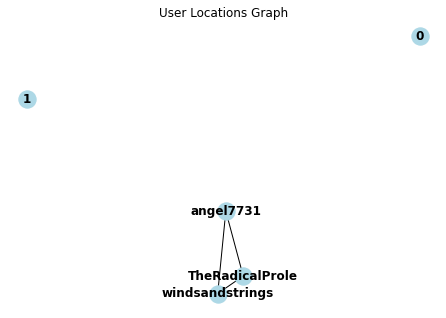

In [ ]:
# plot a relatioship graph

# Create a graph
G = nx.Graph()

# Add nodes to the graph
for index, row in tot_df.iterrows():
    G.add_node(row['Judgement'], name=row['UserName'], location=row['Location'])


# Add edges to the graph
for index, row in tot_df.iterrows():
    for index2, row2 in tot_df.iterrows():
        if row['Location'] == row2['Location'] and row['UserName'] != row2['UserName']:
            G.add_edge(row['UserName'], row2['UserName'])

# Draw the graph
pos = nx.spring_layout(G, k=0.2, iterations=50)
nx.draw(G, pos, node_color='lightblue', with_labels=True, font_weight='bold')

# Set the plot title
plt.title("User Locations Graph")

# Show the plot
plt.show()


In [ ]:
def plot_freq(polarity):
  c_df = final_data.loc[final_data['Highest'] == polarity]
  c_df.drop_duplicates(subset="UserName",
                     keep=False, inplace=True)
  loc_freq = c_df.Location.value_counts()
  freq_loc_pd = pd.DataFrame()
  freq_loc_pd['location'] = loc_freq.index.tolist()
  freq_loc_pd['frequency'] = loc_freq.tolist()
  freq_loc_pd = freq_loc_pd.loc[freq_loc_pd['frequency'] > 2]
  freq_loc_pd.plot(kind='bar',x='location')

In [ ]:
grouped = tot_df.groupby(['Judgement', 'Location']).size().reset_index(name='count')
grouped['Judgement'] = grouped['Judgement'].replace({0: 'Support', 1: 'Hate'})
grouped

,Judgement,Location,count
0,Support,"Alabama, USA",1
1,Support,America,1
2,Support,"California, USA",1
3,Support,"Erie, PA",1
4,Support,Howard University,1
5,Support,Middle distance,1
6,Support,Mountains,1
7,Support,New Zealand,1
8,Support,"Planet Earth, because the alie",1
9,Support,Somewhere. Nowhere. Everywhere,1


In [ ]:
grouped['count']

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    2
Name: count, dtype: int64

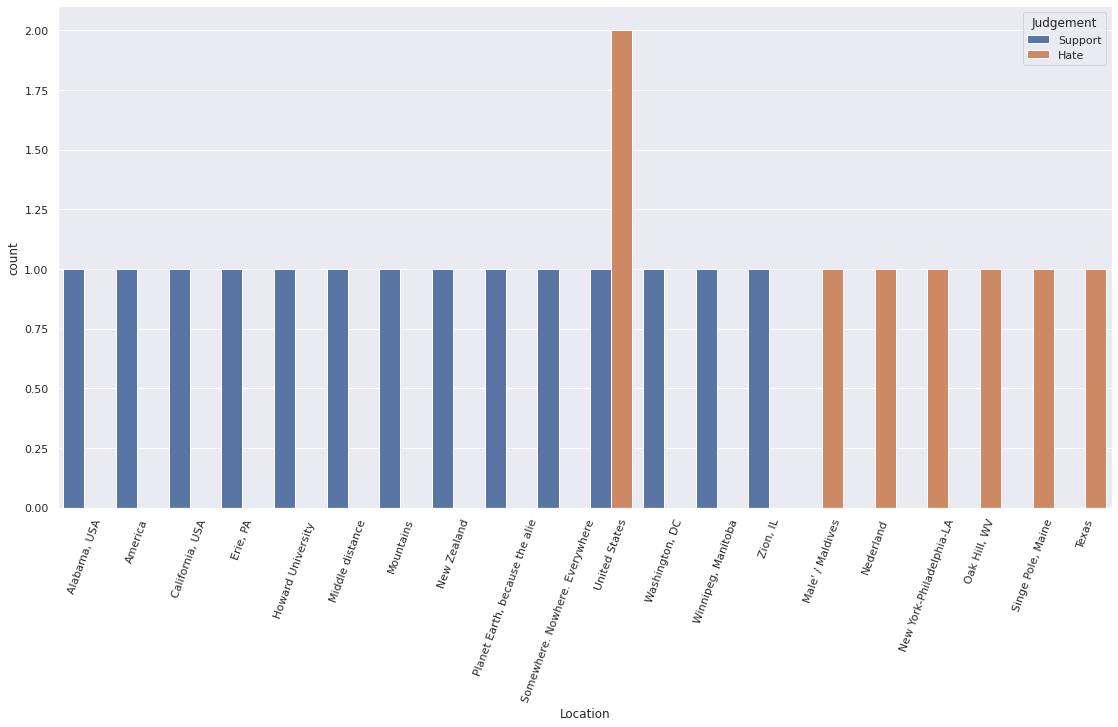

In [ ]:
# plot with seaborn barplot
sns.set(rc={'figure.figsize':(15.7,10.27)})
sns.barplot(data=grouped, x='Location', y='count', hue='Judgement')
plt.xticks(rotation=70)
plt.tight_layout()